# Write a Data Science Blog Post 

# WineEnthusiast: Can it be used as a pricing tool for wineries?

Wine Enthusiast compiles comprehensive reviews of most wines and includes information such as country/region of origin, variety, and reviewer descriptions. This notebook will explore the data to answer three questions to help answer the larger question: Is it possible for wineries to use this data to help them price their wines?

The three questions we will focus on:

1. What are the origins and varieties of wine with the highest pricing?
2. What reviewer descriptors are linked to the highest priced wines?
3. Can we create a model that predicts an optimal price?

## Imports & configuration

In [1]:
# imports
import warnings
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import nltk
from nltk.util import ngrams, everygrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.linear_model import LogisticRegression, PassiveAggressiveRegressor, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import fbeta_score, accuracy_score, make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.feature_selection import SelectKBest, f_regression
from scipy.stats import zscore
from time import time
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import Markdown, display

# configuration
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)
InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings('ignore')

nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

/Users/kfrost/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
[nltk_data] Downloading package punkt to /Users/kfrost/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kfrost/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 1000

<IPython.core.display.Javascript object>

In [3]:
def get_filtered_list(text, stem =False):
    '''
    Receives a string and returns a list of words from text with stop words, 
    punctation, and numerics removed and stemming processed
    '''
    tokens = TweetTokenizer().tokenize(text=text)
    tokens = [w.lower() for w in tokens if (not w in stop_words) and (not w in string.punctuation) and (not w.isnumeric())]
    
    if stem:
        porter = PorterStemmer()
        stems = []
        for t in tokens:    
            stems.append(porter.stem(t))
        return stems
    else:
        return tokens

In [4]:
def filter_outliers(df, column_to_filter, column_to_count):
    '''
    Remove outliers from a dataframe
    '''
    print('Unique ' + column_to_filter + ' values before filtering: ' + str(df[column_to_filter].unique().size))
    
    filtered = df.filter([column_to_filter, column_to_count])  
    median = filtered.groupby([column_to_filter]).count().median()[column_to_count]
    filtered = filtered.groupby([column_to_filter]).count()[column_to_count].reset_index()
    filtered = filtered[filtered[column_to_count] > median][column_to_filter]
    df_after = df[df[column_to_filter].isin(filtered)]
    
    print('Unique ' + column_to_filter + ' values after filtering: ' + str(df_after[column_to_filter].unique().size))
    
    return df_after

In [5]:
def printmd(string):
    '''
    Print markdown text
    '''
    display(Markdown(string))

## Read data and general clean up

In [6]:
# read data
df = pd.read_csv('winemag-data-130k-v2.csv')

In [7]:
df.sample(5)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
103777,103777,Italy,"This charming, easy-drinking blend of Grechetto, Procanico, Malvasia and Verdello opens with a fragrance of yellow flower and spice. The palate offers flavors of tropical fruit, apple and lemon-lime, with a clean, refreshing finish.",NaN,87,10.0,Central Italy,Orvieto Classico,NaN,Kerin O’Keefe,@kerinokeefe,La Carraia 2012 Orvieto Classico,White Blend,La Carraia
88421,88421,US,"Superripe black cherry and dried plum aromas, generous and rich fruit flavors and a smooth texture make this appealing all the way through. Made from Tempranillo and four other varieties, it's boldly flavored but not especially full-bodied, and feels just grippy enough on the palate to go well with burgers and ribs.",Big,87,10.0,California,California,California Other,Jim Gordon,@gordone_cellars,Dark Horse NV Big Red (California),Red Blend,Dark Horse
17737,17737,Portugal,"Mint aromas and flavors lead to an intense wine that is powered at this young stage by firm, serious tannins. It has great richness from the black plum fruits, and a spicy, herbal character that adds complexity. From consultant Luis Duarte, this is a wine for long-term aging; hold for 6–7 years or more.",Rubrica,94,25.0,Alentejano,NaN,NaN,Roger Voss,@vossroger,Luis Duarte 2010 Rubrica Red (Alentejano),Portuguese Red,Luis Duarte
9259,9259,Italy,"Underbrush, oak, wild berry, herb and balsamic notes lead the nose of this Brunello. Tightly wound, fine-grained tannins frame cranberry, red cherry, orange zest and white pepper flavors on the palate. A hint of star anise signals the close. Drink 2020–2027.",NaN,91,55.0,Tuscany,Brunello di Montalcino,NaN,Kerin O’Keefe,@kerinokeefe,Podere Brizio 2012 Brunello di Montalcino,Sangiovese,Podere Brizio
93400,93400,Italy,"Classic aromas truffle, dark-skinned berry, tilled soil and dark baking spice lift out of the glass along with a whiff of menthol. The juicy palate boasts mature Marasca cherry, cinnamon, clove, anise and chopped mint alongside tightly wound tannins and fresh acidity. A hint of tobacco signals the close. Drink 2020–2026.",Fossati,92,70.0,Piedmont,Barolo,NaN,Kerin O’Keefe,@kerinokeefe,Cascina Adelaide 2012 Fossati (Barolo),Nebbiolo,Cascina Adelaide


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             129971 non-null  int64  
 1   country                129908 non-null  object 
 2   description            129971 non-null  object 
 3   designation            92506 non-null   object 
 4   points                 129971 non-null  int64  
 5   price                  120975 non-null  float64
 6   province               129908 non-null  object 
 7   region_1               108724 non-null  object 
 8   region_2               50511 non-null   object 
 9   taster_name            103727 non-null  object 
 10  taster_twitter_handle  98758 non-null   object 
 11  title                  129971 non-null  object 
 12  variety                129970 non-null  object 
 13  winery                 129971 non-null  object 
dtypes: float64(1), int64(2), object(11)


In [9]:
# remove extraneous column
df.drop(['Unnamed: 0', 'region_2', 'points', 'taster_name', 'taster_twitter_handle', 'designation', 'title', 'winery'], axis=1, inplace=True)

In [10]:
# rename column
df.rename(columns={"region_1": "region"}, inplace=True)

In [11]:
# drop any duplicate rows
df.drop_duplicates(inplace=True)

# drop any rows that don't have pricing information
df.dropna(subset=['price'], inplace=True)

In [12]:
# remove outliers with price z-score > 1
df = df[np.abs(zscore(df['price'])) < 1]

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104486 entries, 1 to 129970
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      104431 non-null  object 
 1   description  104486 non-null  object 
 2   price        104486 non-null  float64
 3   province     104431 non-null  object 
 4   region       87123 non-null   object 
 5   variety      104485 non-null  object 
dtypes: float64(1), object(5)
memory usage: 5.6+ MB


## Q1: What are the origins and varieties of wine with the highest pricing?

### 1. Business Understanding

A winery wants to maximize the price the market will support for a given wine. Knowing what the competition in your area is charging might help understand this. What origins produce the highest priced wines? What wine varieties are the most expensive?

### 2. Data Understanding

Let's take a look at our data and see if it might sufficiently answer our question.

In [14]:
# create a copy of the base dataset
df_q1 = df.copy()

In [15]:
df_q1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104486 entries, 1 to 129970
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      104431 non-null  object 
 1   description  104486 non-null  object 
 2   price        104486 non-null  float64
 3   province     104431 non-null  object 
 4   region       87123 non-null   object 
 5   variety      104485 non-null  object 
dtypes: float64(1), object(5)
memory usage: 5.6+ MB


In [16]:
df_q1.sample(10)

,country,description,price,province,region,variety
51953,South Africa,"A decadent blend of ripe berries and rich oak characterizes this wine; sweet smoke and baking spice mingle harmoniously with notes of mashed raspberry and blackberry, accented by hints of hickory-cured bacon and raw cocoa nibs. The medium-weight mouth is structured and bold, with chewy tannins and heady flavors of plum and berry preserves, roasted coffee and sweet licorice. The finish is long and dry, and although this would certainly benefit from 5–10 years of cellaring time, it's approachable now with decanting.",38.0,Stellenbosch,NaN,Pinotage
121449,France,"This wine is well balanced, ripe with apricot and white-peach flavors that contrast with the kiwi and grapefruit freshness. A more mineral edge gives texture. This delicious wine will be even better to drink from 2017.",29.0,Burgundy,Pouilly-Fuissé,Chardonnay
51311,US,"The aromas on this bottling are inoffensive but a bit flat, with broad nectarine and light orange touches. There is a citrus twist to the palate and a touch of wet cement.",15.0,California,Paso Robles,Sauvignon Blanc
44284,US,"Made from Moscato di Canelli, this dessert wine is more like a still wine in bouquet, not exuding sweet as much as floral. On the palate, it's a different story, taking on richness and thickness around flavors of baked apple and nutmeg, finding a good balance on the finish.",25.0,California,Napa Valley,Moscato
104510,Portugal,"This is a fruity wine housing soft tannins and red berry fruit notes. It's rounded and smooth, with streaks of vanilla highlighting the finish. Drink now.",7.0,Alentejo,NaN,Portuguese Red
104566,US,"This very fairly priced wine from the fourth-generation winemaking family behind San Antonio Winery delivers aromas of black cherry-crusted charred meats with significant mint character. It's dense on the palate and quite tannic, but quite nice with blackberry paste, licorice and tanned leather flavors.",20.0,California,Paso Robles,Merlot
117745,France,"This has firm tannins, and it demonstrates the potential of its juicy fruit flavors. With its powerful structure, this is a slowly developing selection that needs at least five years in a cellar.",57.0,Burgundy,Beaune,Pinot Noir
57698,Italy,"This plush, rich expression of Pinot Grigio from northeast Italy would pair with white meat, seafood risotto or spicy dishes from the Far East. The mouthfeel is smooth, rich and long-lasting.",28.0,Northeastern Italy,Friuli Isonzo,Pinot Grigio
1435,US,"The 2010 Bello Rosso sticks to the 50-50 Sangiovese, Cabernet Sauvignon formula, with a full, round, ripe and balanced palate. Fruity and forward, with citrus-accented cherry fruit, it pulls together the strengths of both grapes, with taut acidity and firm tannins.",32.0,Washington,Columbia Valley (WA),Cabernet Sauvignon-Sangiovese
8995,France,"Named after the steep slopes that back the Bourgeois winery, this powerful, concentrated wine shows both wonderful white and yellow fruits and a mineral character that gives a superb tension. Packed with fruit and impressively textured, it can still age. Drink from 2017.",35.0,Loire Valley,Sancerre,Sauvignon Blanc


We don't need the description column to answer this question. We will also want to remove any outliers in the next section.

### 3. Prepare Data

In [17]:
# drop extraneous columns
df_q1.drop(['description'], axis=1, inplace=True)

In [18]:
df_q1.sample(10)

,country,price,province,region,variety
85817,Spain,25.0,Galicia,Rías Baixas,Albariño
14245,US,19.0,Oregon,Willamette Valley,Pinot Gris
10058,Spain,19.0,Northern Spain,Vino de la Tierra de Castilla y León,Verdejo
17459,US,20.0,Oregon,Willamette Valley,Arneis
111005,Canada,23.0,Ontario,Niagara Peninsula,Riesling
31850,France,35.0,Alsace,Alsace,Pinot Noir
75174,Italy,60.0,Piedmont,Barolo,Nebbiolo
120082,France,45.0,Burgundy,Beaune,Pinot Noir
81883,Bulgaria,10.0,Thracian Valley,NaN,Cabernet Sauvignon
4396,US,35.0,California,Anderson Valley,Pinot Noir


In [19]:
# remove outliers from the dataframe
df_q1 = filter_outliers(df_q1, "country", "price")
df_q1 = filter_outliers(df_q1, "province", "price")
df_q1 = filter_outliers(df_q1, "region", "price")
df_q1 = filter_outliers(df_q1, "variety", "price").reset_index(drop=True)
df_q1

Unique country values before filtering: 43
Unique country values after filtering: 21
Unique province values before filtering: 357
Unique province values after filtering: 175
Unique region values before filtering: 1150
Unique region values after filtering: 565
Unique variety values before filtering: 466
Unique variety values after filtering: 223


,country,price,province,region,variety
0,US,14.0,Oregon,Willamette Valley,Pinot Gris
1,US,13.0,Michigan,Lake Michigan Shore,Riesling
2,US,65.0,Oregon,Willamette Valley,Pinot Noir
3,Italy,16.0,Sicily & Sardinia,Vittoria,Frappato
4,France,24.0,Alsace,Alsace,Gewürztraminer
...,...,...,...,...,...
84139,France,28.0,Alsace,Alsace,Pinot Gris
84140,US,75.0,Oregon,Oregon,Pinot Noir
84141,France,30.0,Alsace,Alsace,Gewürztraminer
84142,France,32.0,Alsace,Alsace,Pinot Gris


<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

[Text(0, 0.5, 'Country of Origin'),
 Text(0.5, 0, 'Wine Price'),
 Text(0.5, 1.0, 'Top/Bottom Median Price of Wines by Country of Origin')]

<Figure size 864x576 with 0 Axes>

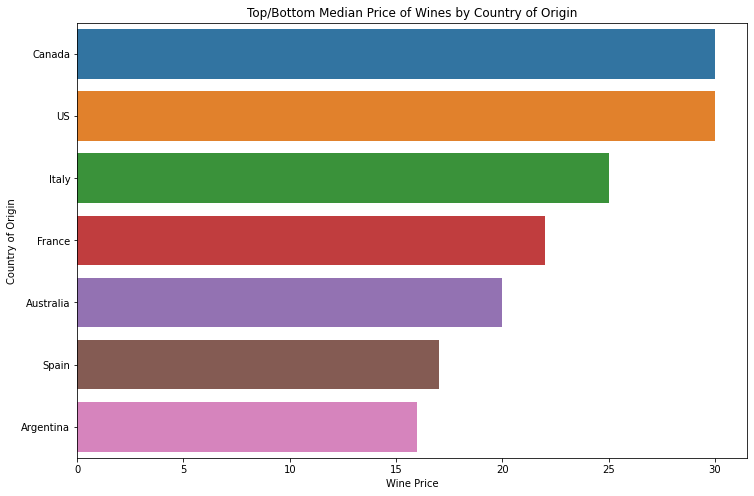

In [20]:
# create a bar chart to illustrate prices by country of origin
plt.figure(figsize=(12,8))

# group by country and sort by highest price
by_country = df_q1.groupby(['country']).median().sort_values(by=['price'], ascending=False).reset_index()

plt.figure(figsize=(12,8))
ax = sns.barplot(x="price", y="country", data=by_country)
ax.set(xlabel='Wine Price', ylabel='Country of Origin', title='Top/Bottom Median Price of Wines by Country of Origin')
plt.show()

<Figure size 864x576 with 0 Axes>

[Text(0, 0.5, 'Wine Variety'),
 Text(0.5, 0, 'Wine Price'),
 Text(0.5, 1.0, 'Top/Bottom Median Price of Wine by Variety')]

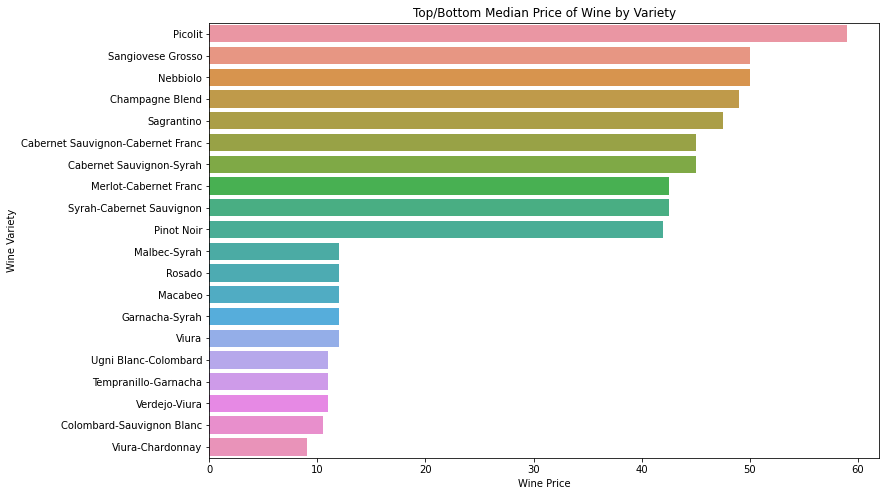

In [21]:
# group by variety and sort by highest price
by_variety = df_q1.groupby(['variety']).median().sort_values(by=['price'], ascending=False).reset_index()

# create a bar chart to illustrate prices by variety
plt.figure(figsize=(12,8))
ax = sns.barplot(x="price", y="variety", data=pd.concat([by_variety.head(10), by_variety.tail(10)]))
ax.set(xlabel='Wine Price', ylabel='Wine Variety', title='Top/Bottom Median Price of Wine by Variety')
plt.show()

<Figure size 864x576 with 0 Axes>

[Text(0, 0.5, 'Region of Origin'),
 Text(0.5, 0, 'Wine Price'),
 Text(0.5, 1.0, 'Top/Bottom Median Price of Wine by Region')]

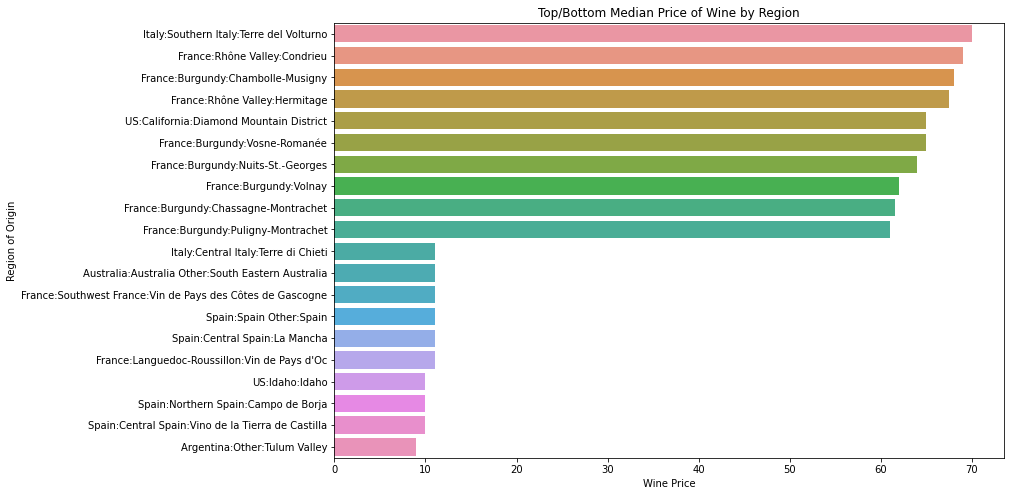

In [22]:
# group by country/province/region and sort by highest price
by_region = df_q1.groupby(['country', 'province', 'region']).median().sort_values(by=['price'], ascending=False).reset_index()
by_region_top_bottom = pd.concat([by_region.head(10), by_region.tail(10)])
by_region_top_bottom['combined'] = by_region['country'] + ":" + by_region['province'] + ":" + by_region['region']

# create a bar chart to illustrate prices by region
plt.figure(figsize=(12,8))
ax = sns.barplot(x="price", y="combined", data=by_region_top_bottom)
ax.set(xlabel='Wine Price', ylabel='Region of Origin', title='Top/Bottom Median Price of Wine by Region')
plt.show()

#### Are certain countries producing more of one type of wine that might skew the results? Let's normalize for variety.

In [23]:
def compare_price_normalizing_variety(x):
    '''
    return price ratio after normalizing for variety
    '''
    y = by_variety[by_variety['variety'] == x.variety]['price']
    return x.price / y.iloc[0] if y is not None and y.size > 0 else None 

In [24]:
# group by country/variety and normalize price
country_normalized_variety = df_q1.groupby(['country', 'variety']).median().sort_values(by=['price'], ascending=False).reset_index()
country_normalized_variety['ratio'] = country_normalized_variety.apply(lambda x: compare_price_normalizing_variety(x), axis=1)

<Figure size 864x576 with 0 Axes>

[Text(0, 0.5, 'Country of Origin'),
 Text(0.5, 0, 'Price Ratio'),
 Text(0.5, 1.0, 'Top Origin Country Prices Normalized By Variety')]

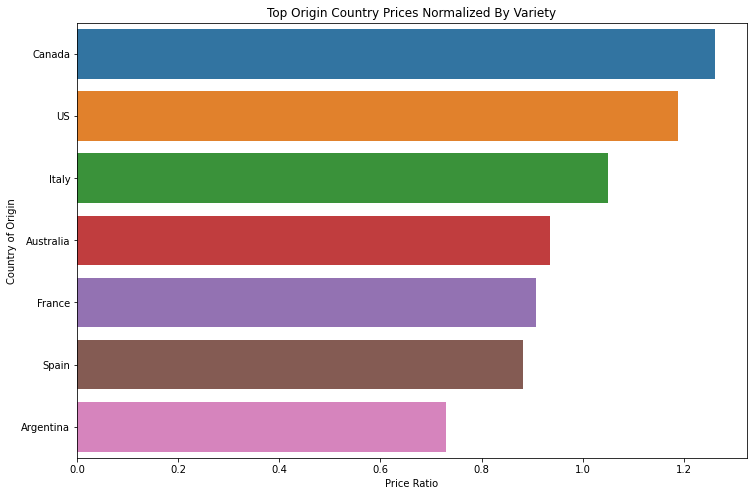

In [25]:
# group by country and sort by highest ratio
country_normalized_variety_diff = country_normalized_variety.groupby(['country']).mean().sort_values(by=['ratio'], ascending=False).reset_index()

# create bar chart
plt.figure(figsize=(12,8))
ax = sns.barplot(x="ratio", y="country", data=country_normalized_variety_diff)
ax.set(xlabel='Price Ratio', ylabel='Country of Origin', title='Top Origin Country Prices Normalized By Variety')
plt.show()

#### Are certain varieties only grown in certain countries thus skewing the results? Let's normalize for country.

In [26]:
def compare_price_normalizing_country(x):
    '''
    return price ratio after normalizing for country
    '''
    y = by_country[by_country['country'] == x.country]['price']
    return x.price / y.iloc[0] if y is not None and y.size > 0 else None 

In [27]:
# group by country/variety and normalize price
variety_normalized_country = df_q1.groupby(['country', 'variety']).median().sort_values(by=['price'], ascending=False).reset_index()
variety_normalized_country['ratio'] = variety_normalized_country.apply(lambda x: compare_price_normalizing_country(x), axis=1)

<Figure size 864x576 with 0 Axes>

[Text(0, 0.5, 'Wine Variety'),
 Text(0.5, 0, 'Price Ratio'),
 Text(0.5, 1.0, 'Top Wine Variety Prices Normalized By Country')]

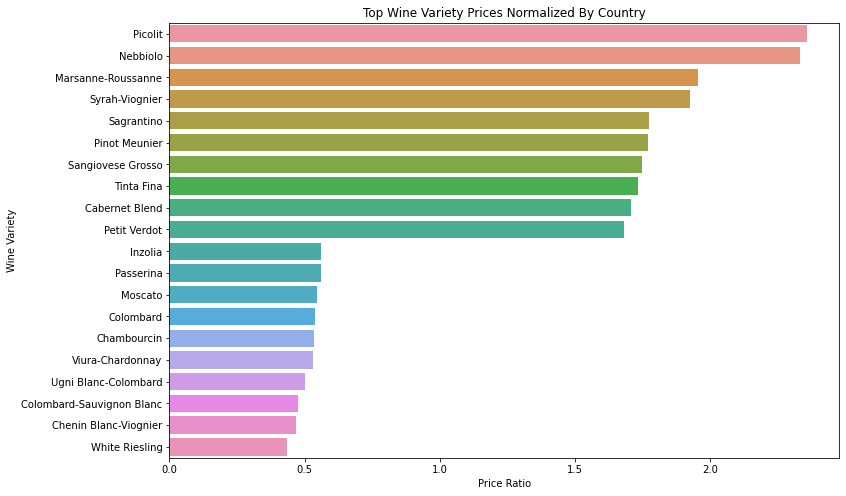

In [28]:
# group by country and sort by highest ratio
variety_normalized_country_diff = variety_normalized_country.groupby(['variety']).mean().sort_values(by=['ratio'], ascending=False).reset_index()

# create bar chart
plt.figure(figsize=(12,8))
ax = sns.barplot(x="ratio", y="variety", data=pd.concat([variety_normalized_country_diff.head(10), variety_normalized_country_diff.tail(10)]))
ax.set(xlabel='Price Ratio', ylabel='Wine Variety', title='Top Wine Variety Prices Normalized By Country')
plt.show()

### 4. Evaluate the Results

The graphs above clearly show there is a large variance between countries, varieties, and regions. The US and Canada have the highest priced wines, while Spain and Argentina have the lowest. Picolit and Nebbiolo are the highest priced varieties, while Chenin Blanc-Viognier and White Riesling are the lowest.

This data obviously ignores variables like cost to develop, taxes, etc that might affect the price and profit. Our intent is only to show how the data present in WineEnthusiast might help a winery set their initial pricing range.

## Q2: What reviewer descriptors are linked to the highest priced wines?

### 1. Business Understanding

The WineEnthusiast data includes text reviews for each wine by an expert reviewer. Do these experts use common words to describe higher or lower priced wines? Could a winery hire a reviewer and use the review to help price the wine?

### 2. Data Understanding

In [29]:
df_q2 = df.copy()

In [30]:
df_q2.head()

,country,description,price,province,region,variety
1,Portugal,"This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's already drinkable, although it will certainly be better from 2016.",15.0,Douro,NaN,Portuguese Red
2,US,"Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented.",14.0,Oregon,Willamette Valley,Pinot Gris
3,US,"Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.",13.0,Michigan,Lake Michigan Shore,Riesling
4,US,"Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew.",65.0,Oregon,Willamette Valley,Pinot Noir
5,Spain,"Blackberry and raspberry aromas show a typical Navarran whiff of green herbs and, in this case, horseradish. In the mouth, this is fairly full bodied, with tomatoey acidity. Spicy, herbal flavors complement dark plum fruit, while the finish is fresh but grabby.",15.0,Northern Spain,Navarra,Tempranillo-Merlot


To answer this question, we do not need any information about the winery location or the wine variety. We will remove these columns in the next section.

### 3. Prepare Data

In [31]:
# drop columns
df_q2.drop(['country', 'province', 'region', 'variety'],
           axis=1, inplace=True)

In [32]:
df_q2.sample(10)

,description,price
36165,"Here is a generous, full-throttle, high-octane Zin, with lots of rich oak accents and a touch of sweetness. Aromas of strawberry jam, maple syrup and hickory-smoked bacon are followed by rich fruit flavors, full body, light tannins and a jammy finish.",20.0
61734,"Named for the Servite convent in the town of Borba, this fresh, crisp and tangy wine is citric, with almond and apple overtones. It's young, fruity and made for immediate consumption.",7.0
46457,"A healthy wine with plenty of oak. On the nose, it's charred as well as fruity, with raspberry and plum aromas blending with vanilla. Feels tight and grippy, with dry oak, herbal flavors and fresh red berry and tomato. Finishes clean and snappy, with correct weight and length. Drink now through 2013.",15.0
55577,"Vibrant, tart aromas of green gooseberries and lime rind elevate the underlying hay and fresh thyme herbal accents. Lean, barely ripe white peach and hard pear add volume to the medium-weight mouth. Balanced and seamless with a clean, refreshing finish. Drink up!",10.0
112359,"The lighter-style nose that focuses on red plum and cherry is a welcome change from all of the heavy Malbecs out there, but the wine doesn't follow through on the palate. It becomes astringent, with tastes of tomato, stewed berry and cranberry.",17.0
3290,"The bouquet here is very floral and intense: you'll get jasmine, honeysuckle, sweet apple, mango and other exotic fruits. The wine tastes clean, sweet and dense and has fragrant flavors that accompany you glass after glass.",18.0
101999,"Opens with light but earthy raspberry aromas and plum, and then it breaks up a bit with airing. The palate is lean but fresh and gritty, with cherry and cola flavors in front of a limited, narrow finish. Run-of-the-mill, which isn't bad given the price.",8.0
41181,"A bit more lacy and less fleshy than the previous vintage, it augments its strawberry and raspberry fruit with barrel notes of baking spices and a hint of char. Give it plenty of breathing time and it pulls together nicely.",38.0
124396,"A standout in a flight of more expensive wines, this five-grape blend leans heavily on the Bordeaux varietals, with a bit of Syrah as well. Firm and complex, its black cherry, cassis and plum fruit flavors are nicely accented by baking spices and red licorice. The balance is perfect; the finish carries a suggestion of dried leaf.",19.0
56943,"Soupy, volatile plum and berry aromas are stalky. The palate is adequate but sticky, while saucy but sweet plum flavors fall off quickly on the finish.",8.0


In [33]:
# filter the descriptions removing stop words, punctation, and numerics. Return the list of words
description = df_q2['description'].apply(get_filtered_list).explode().to_frame()
description.rename(columns={"description": "word"}, inplace=True)

# merge words with main data frame
words = pd.concat([df_q2, description], axis=1).drop(columns=['description']).reset_index(drop=True)

In [34]:
# only use descriptor words with 100 instances and find the mean price
means = words.groupby(['word']).filter(lambda x: len(x['price']) > 100).groupby(['word']).price.agg('mean').to_frame('mean').reset_index()
means = means.sort_values(by=['mean'], ascending=False).reset_index(drop=True)

### 4. Evaluate the Results

<Figure size 864x1800 with 0 Axes>

[Text(0, 0.5, 'Word'),
 Text(0.5, 0, 'Mean Price'),
 Text(0.5, 1.0, 'Top/Bottom 25 Descriptor Words By Mean Price')]

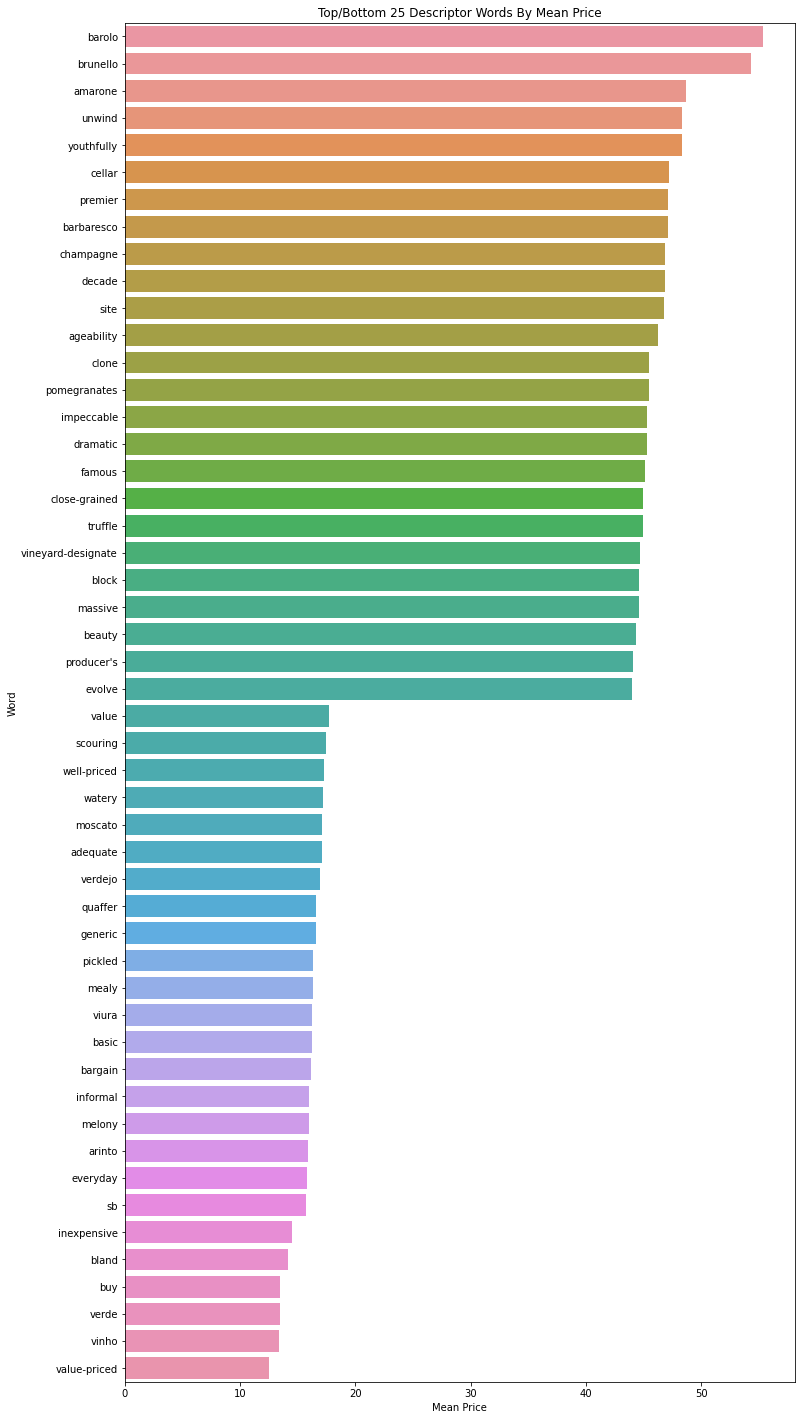

In [35]:
# create a bar chart to show mean price of the 50 most used descriptor words
plt.figure(figsize=(12,25))
ax = sns.barplot(x="mean", y="word", data=pd.concat([means.head(25), means.tail(25)]))
ax.set(xlabel='Mean Price', ylabel='Word', title='Top/Bottom 25 Descriptor Words By Mean Price')
plt.show()

The chart above illustrates the words that are commonly found in high and low priced wines. In the next section we will determine if this data can be used in our model.

## Q3: Can we create a model that predicts an optimal price?

### 1. Business Understanding

We've seen charts above that show different features of high and low priced wine. Can we use these features to create a model that might predict a target price for a new wine? The next sections will explore this question.

### 2. Data Understanding

In [36]:
df_q3 = df.copy()

In [37]:
df_q3.head(10)

,country,description,price,province,region,variety
1,Portugal,"This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's already drinkable, although it will certainly be better from 2016.",15.0,Douro,NaN,Portuguese Red
2,US,"Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented.",14.0,Oregon,Willamette Valley,Pinot Gris
3,US,"Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.",13.0,Michigan,Lake Michigan Shore,Riesling
4,US,"Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew.",65.0,Oregon,Willamette Valley,Pinot Noir
5,Spain,"Blackberry and raspberry aromas show a typical Navarran whiff of green herbs and, in this case, horseradish. In the mouth, this is fairly full bodied, with tomatoey acidity. Spicy, herbal flavors complement dark plum fruit, while the finish is fresh but grabby.",15.0,Northern Spain,Navarra,Tempranillo-Merlot
6,Italy,"Here's a bright, informal red that opens with aromas of candied berry, white pepper and savory herb that carry over to the palate. It's balanced with fresh acidity and soft tannins.",16.0,Sicily & Sardinia,Vittoria,Frappato
7,France,"This dry and restrained wine offers spice in profusion. Balanced with acidity and a firm texture, it's very much for food.",24.0,Alsace,Alsace,Gewürztraminer
8,Germany,"Savory dried thyme notes accent sunnier flavors of preserved peach in this brisk, off-dry wine. It's fruity and fresh, with an elegant, sprightly footprint.",12.0,Rheinhessen,NaN,Gewürztraminer
9,France,This has great depth of flavor with its fresh apple and pear fruits and touch of spice. It's off dry while balanced with acidity and a crisp texture. Drink now.,27.0,Alsace,Alsace,Pinot Gris
10,US,"Soft, supple plum envelopes an oaky structure in this Cabernet, supported by 15% Merlot. Coffee and chocolate complete the picture, finishing strong at the end, resulting in a value-priced wine of attractive flavor and immediate accessibility.",19.0,California,Napa Valley,Cabernet Sauvignon


### 3. Prepare Data

In [38]:
# remove outliers from the dataframe
df_q3 = filter_outliers(df_q3, "country", "price")
df_q3 = filter_outliers(df_q3, "province", "price")
df_q3 = filter_outliers(df_q3, "region", "price")
df_q3 = filter_outliers(df_q3, "variety", "price").reset_index(drop=True)
df_q3.shape

Unique country values before filtering: 43
Unique country values after filtering: 21
Unique province values before filtering: 357
Unique province values after filtering: 175
Unique region values before filtering: 1150
Unique region values after filtering: 565
Unique variety values before filtering: 466
Unique variety values after filtering: 223


(84144, 6)

In [39]:
# Split the data into features and target label
df_price = df_q3['price']
df_features = df_q3.drop(['price'], axis = 1)

In [40]:
# Filter descriptions to remove unneeded words
corpus = df_features['description'].apply(get_filtered_list).apply(lambda l: ' '.join(l))

In [41]:
# Create a matrix of TF-IDF features. Only use the top 100 terms by frequency
tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True, max_features=100)
tv_matrix = tv.fit_transform(corpus)
tv_matrix = tv_matrix.toarray()

# Create a new dataframe for the word matrices 
vocab = tv.get_feature_names()
df_words = pd.DataFrame(np.round(tv_matrix, 2), columns=vocab)

In [42]:
# Drop description column and merge with word dataframe
df_features = df_features.drop(['description'], axis = 1).reset_index(drop=True)
df_features = pd.concat([df_features, df_words], axis=1)

In [43]:
# One-hot encode categorical features
df_features_final = pd.get_dummies(df_features)

In [44]:
# Print the number of features after one-hot encoding
encoded = list(df_features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

945 total features after one-hot encoding.


In [45]:
# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_features_final, 
                                                    df_price, 
                                                    test_size = 0.33)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 56376 samples.
Testing set has 27768 samples.


### 4. Create a model

In [46]:
# Initialize the classifier
clf = LogisticRegression(max_iter=100, verbose=10, warm_start=True, n_jobs=4, C=1, solver='saga', penalty='l1')

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)

# Report the before-and-afterscores
print("Mean squared error on testing data: {:.4f}".format(mean_squared_error(y_test, predictions)))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


max_iter reached after 2893 seconds


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed: 48.2min
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed: 48.2min finished


Mean squared error on testing data: 177.7639


### 5. Evaluate the Results

Our trained model produced a mean squared error of 177.7639. This equates to an error of 13.33. This is not ideal when the average bottle of wine is around $25. This model would not be accurate enough to properly predict the price. In future analysis, we could explore other classifier types to improve the results.